# Explore GRS images

## Load python libraries

In [2]:

import glob
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray  # activate the rio accessor


import pyproj as ppj

#import cartopy
import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#import locale
#locale.setlocale(locale.LC_ALL, 'en_US.utf8')
import matplotlib.pyplot as plt
import matplotlib as mpl

import panel as pn

import grs
import grstbx
from grstbx import visual

u = grstbx.utils
opj = os.path.join


print(f'-grs: {grs.__version__}')
print(f'-grstbx: {grstbx.__version__}')

-grs: 2.2.0
-grstbx: 2.0.2


## Set the images you want to play with

In [3]:
workdir ='/data/satellite/Sentinel-2/subset/hypernets/L2A/BEFR/'#32TQR/2021/07'
#workdir ='/data/tmp'
#workdir = '/DATA/git/satellite_app/grs/'
#workdir = '/data/test/'
files = pn.widgets.FileSelector(workdir)
files

FileSelector(directory='/data/satellite/Sentinel-...)

In [4]:
files = files.value

In [5]:
#files=['/data/satellite/Sentinel-2/L2A/24MWU/2023/08/31/S2B_MSIL2Agrs_20230831T130249_N0509_R095_T24MWU_20230831T144212']
# generate datacube
dc = grstbx.L2grs(files)
dc.get_l2a_datacube(nodata_thresh=1.)

l2a_prod=dc.datacube.isel(time=0).squeeze().load()

In [6]:
v=visual.ViewSpectral(l2a_prod.Rrs.where(l2a_prod.mask==0),reproject=True)
v.minmax=[0,0.1]
v.minmaxvalues=(0,0.04)
v.visu()

Column
    [0] WidgetBox
        [0] Markdown(str)
        [1] Column
            [0] Row
                [0] Markdown(str)
                [1] RadioButtonGroup(options=[0, 1, 2, 3, 4, ...], value=2)
            [1] Row
                [0] Row
                    [0] Markdown(str)
                    [1] DatePicker(enabled_dates=[datetime.date(2022, ...], start=datetime.date(2022, ..., value=datetime.date(2022, ...)
                [1] Row
                    [0] Markdown(str)
                    [1] Select(options=['CartoDark', ...], value='CartoDark')
            [2] Row
                [0] Row
                    [0] Markdown(str)
                    [1] EditableRangeSlider(end=0.1, name='Range Slider', step=0.0001, value=(0, 0.04), width=300)
                [1] Row
                    [0] Markdown(str)
                    [1] FloatSlider(name='Opacity', step=0.05, value=0.95)
                [2] Row
                    [0] Markdown(str)
                    [1] Select(options=['CET_D13', 'bky', ...], value='CET_D13')
        [2] HoloViews(DynamicMap, height=800, sizing_mode='fixed', width=1200)

In [17]:
geom_ = v.get_geom(v.aoi_stream,crs=l2a_prod.rio.crs)

raster = xr.Dataset()

for param in l2a_prod.keys():
    da = l2a_prod[param].where(l2a_prod.mask==0)
    if 'x' in da.dims and 'y' in da.dims:
        raster[param]=da.rio.clip(geom_.geometry.values)
    else:
        raster[param]=da
raster.attrs = l2a_prod.attrs
# reassign flag dtype, bug from rasterio that converts int32 into float
raster["flags"]=raster.flags.astype(np.int32)

In [18]:
str_epsg = str(dc.datacube.rio.crs)
zone = str_epsg[-2:]
is_south = str_epsg[2] == 7
proj = ccrs.UTM(zone, is_south)

In [19]:
l2a_prod

<xarray.Dataset> Size: 369MB
Dimensions:                          (y: 1280, x: 1280, wl: 11)
Coordinates:
    time                             datetime64[ns] 8B 2022-08-12T10:30:31
  * wl                               (wl) int64 88B 443 490 560 ... 1610 2190
  * x                                (x) float64 10kB 6.57e+05 ... 6.826e+05
  * y                                (y) float64 10kB 4.828e+06 ... 4.802e+06
    spatial_ref                      int64 8B 0
Data variables: (12/22)
    aot550                           (y, x) float64 13MB 0.359 0.359 ... 0.353
    Rrs                              (wl, y, x) float64 144MB nan nan ... nan
    BRDFg                            (wl, y, x) float64 144MB nan nan ... nan
    vza                              (y, x) float64 13MB 6.75 6.74 ... 4.32 4.32
    sza                              (y, x) float64 13MB nan nan nan ... nan nan
    raa                              (y, x) float64 13MB 326.3 326.3 ... 299.7
    ...                               ...
    flag_thin_cirrus                 float64 8B 0.0
    flag_opac_cirrus                 float64 8B 0.0
    flag_high_swir                   float64 8B 0.2112
    flag_surfwater_land              float64 8B 0.0
    flag_surfwater_water             float64 8B 1.0
    flag_surfwater_cloud_and_shadow  float64 8B 0.0
Attributes: (12/74)
    long_name:                           CA BLUE GREEN RED VRE_1 VRE_2 VRE_3 ...
    constellation:                       Sentinel-2
    constellation_id:                    S2
    product_path:                        /data/satellite/Sentinel-2/L1C/31TFJ...
    product_name:                        S2A_MSIL1C_20220812T103031_N0400_R10...
    product_filename:                    S2A_MSIL1C_20220812T103031_N0400_R10...
    ...                                  ...
    dirdata:                             /data/grs/grsdata
    abs_gas_file:                        /home/harmel/Dropbox/Dropbox/work/gi...
    water_vapor_transmittance_file:      /home/harmel/Dropbox/Dropbox/work/gi...
    metadata_profile:                    datacube
    start_date:                          2022-08-12T10:30:31.000000000
    stop_date:                           2022-08-12T10:30:31.000000000

In [20]:
raster.flags.astype(np.int32)

<xarray.DataArray 'flags' (y: 1158, x: 1278)> Size: 6MB
array([[-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       ...,
       [        536,         536,         536, ..., -2147483648,
        -2147483648, -2147483648],
       [        536,         536,         536, ..., -2147483648,
        -2147483648, -2147483648],
       [        536,         536,         536, ..., -2147483648,
        -2147483648, -2147483648]], dtype=int32)
Coordinates:
    time         datetime64[ns] 8B 2022-08-12T10:30:31
  * x            (x) float64 10kB 6.57e+05 6.571e+05 ... 6.826e+05 6.826e+05
  * y            (y) float64 9kB 4.826e+06 4.826e+06 ... 4.802e+06 4.802e+06
    spatial_ref  int64 8B 0
Attributes:
    flag_descriptions:  ['nodata in input image', 'low confidence cloud mask ...
    flag_names:         ['nodata', 'cloud_p06', 'cloud_p08', 'water_swir_visi...

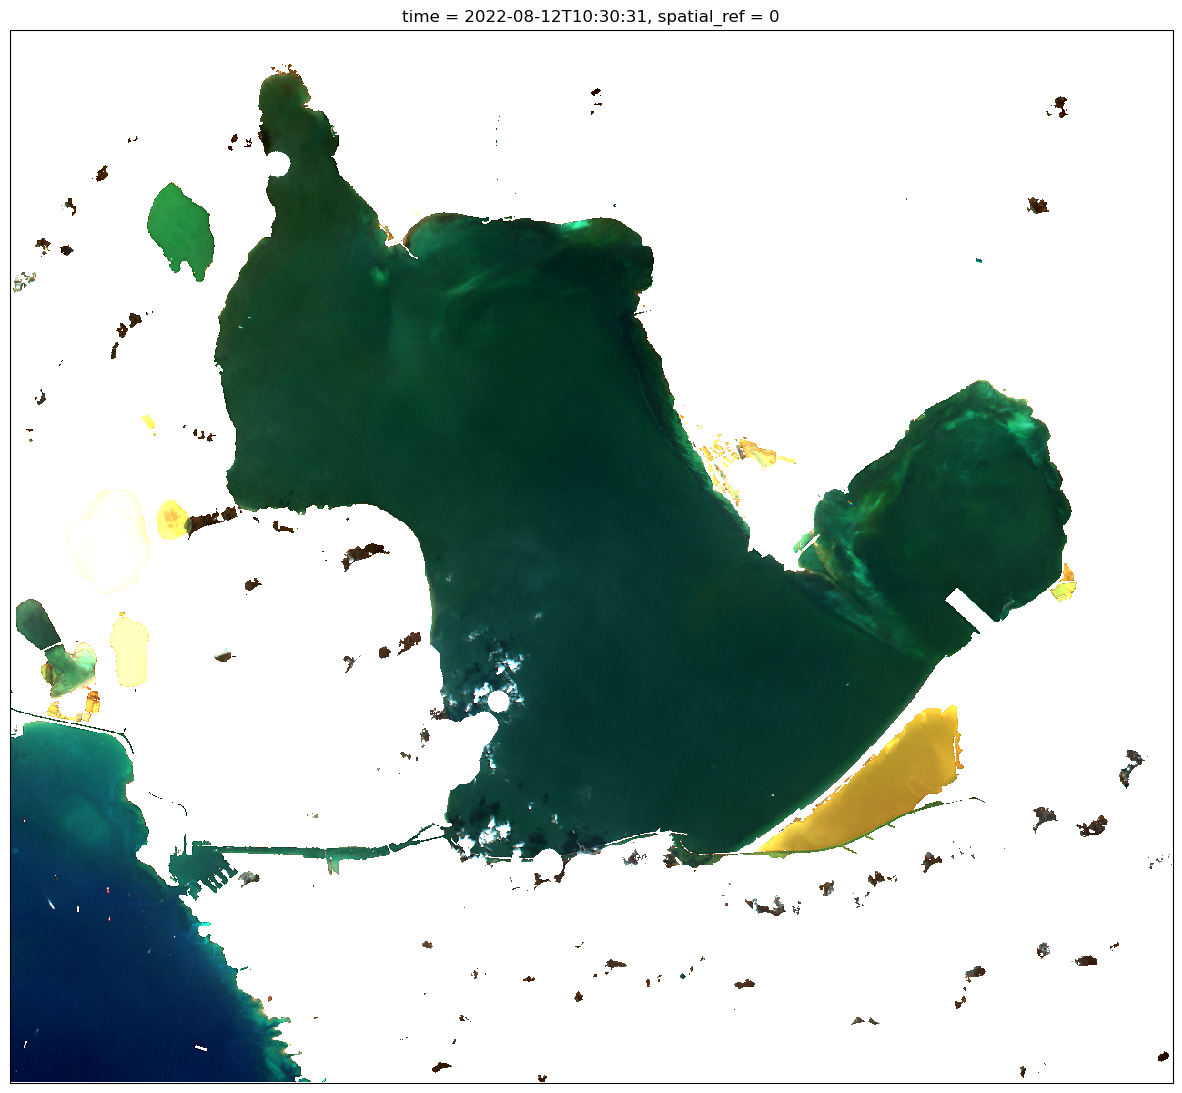

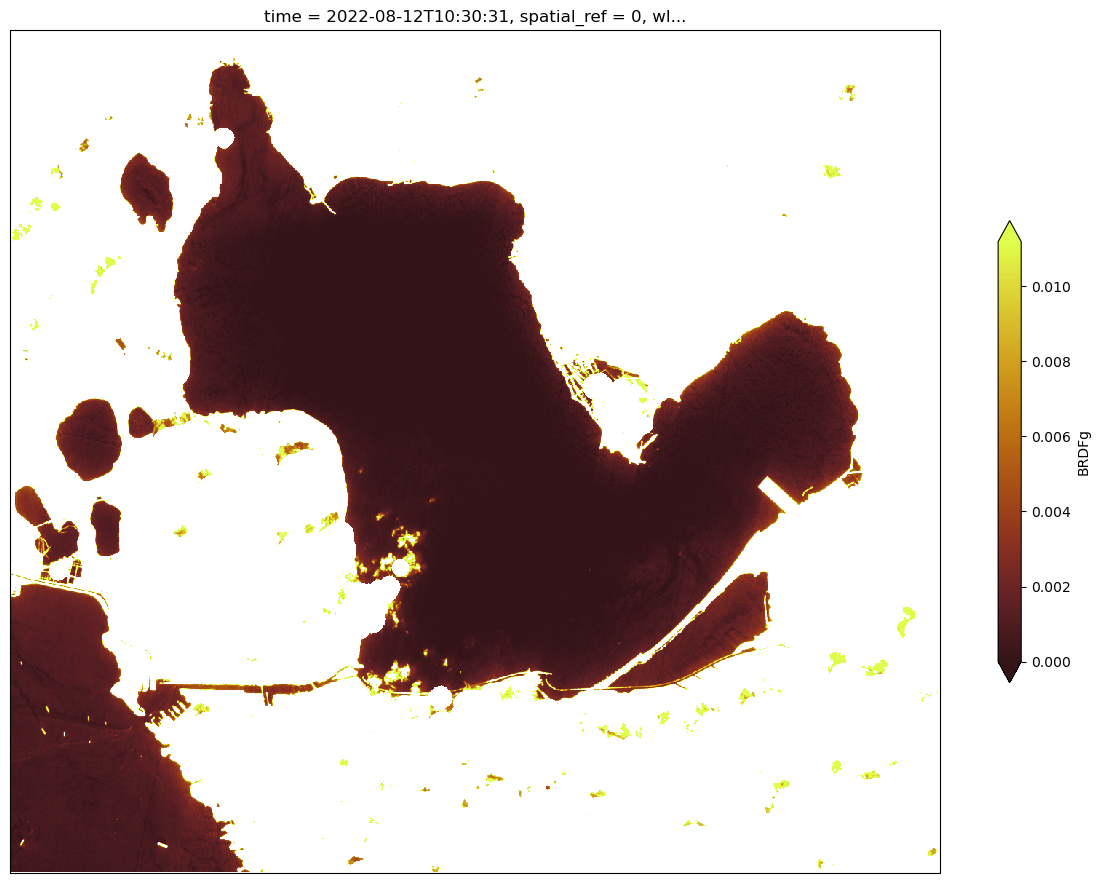

In [22]:
import cmocean as cmo
alpha=0.5

plt.figure(figsize=(15,15))
(raster.Rrs.sel(wl=[705,560,490],method='nearest')).plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection=proj))
# get landmask (third bit)
bcmap = mpl.colors.ListedColormap([(0,0,0,0),'green'])
flag_value = 1 << 5
((raster.flags.astype(np.int32) & flag_value) != 0).plot.imshow(cmap=bcmap,alpha=alpha,add_colorbar=False)
# get cloud p06 (second bit)
bcmap = mpl.colors.ListedColormap([(0,0,0,0),'red'])
flag_value = int('0010', 2)
((raster.flags & flag_value) != 0).plot.imshow(cmap=bcmap,alpha=alpha,add_colorbar=False)
# get cloud p08 (third bit)
bcmap = mpl.colors.ListedColormap([(0,0,0,0),'khaki'])
flag_value = int('0100', 2)
((raster.flags & flag_value) != 0).plot.imshow(cmap=bcmap,alpha=alpha,add_colorbar=False)

plt.figure(figsize=(15,15))
raster.BRDFg.isel(wl=0).plot.imshow(cmap= cmo.cm.solar, robust=True,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.4},vmin=0)

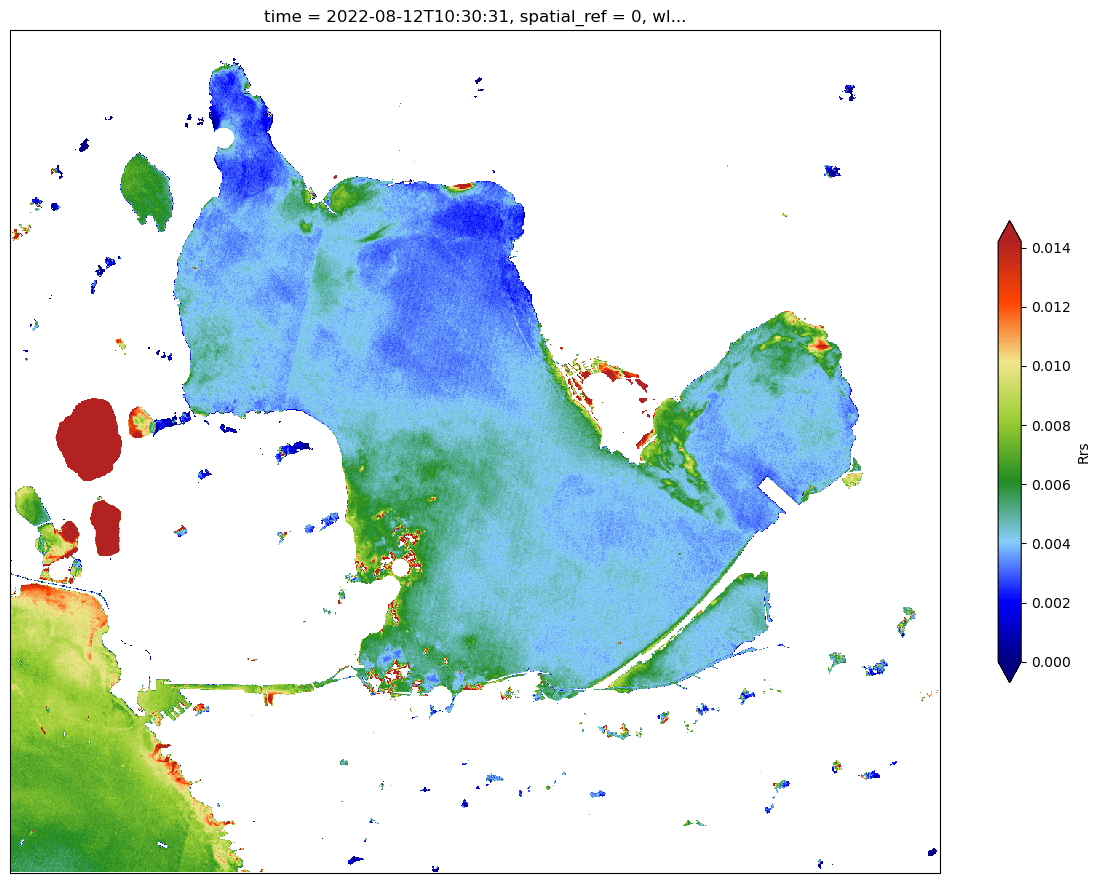

In [23]:
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list("",
                                                    ['navy', "blue", 'lightskyblue',
                                                   'forestgreen','yellowgreen',
                                                    "khaki",# "gold",
                                                     'orangered', 
                                                     "firebrick"])
plt.figure(figsize=(15,15))
(raster.Rrs.sel(wl=490,method='nearest')).plot.imshow(cmap=cmap, robust=True,subplot_kws=dict(projection=proj),vmin=0.0,vmax=0.0142,cbar_kwargs={'shrink':0.4})

In [24]:
raster['Rrs']=raster.Rrs.where((raster.mask==0) & (raster.Rrs.isel(wl=1)<0.0425))
raster['BRDFg']=raster.BRDFg.where((raster.mask==0) & (raster.Rrs.isel(wl=1)<0.0425))

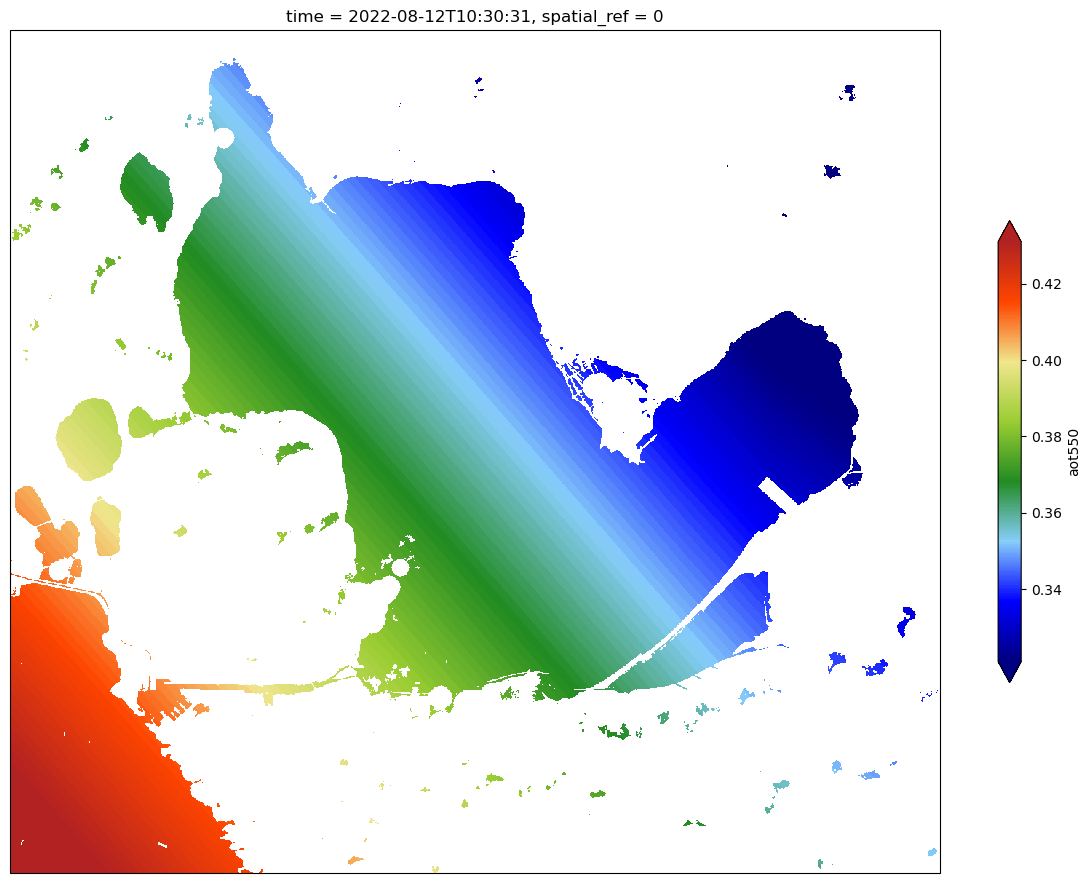

In [25]:
plt.figure(figsize=(15,15))
raster.aot550.plot.imshow(cmap=cmap, robust=True,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.4})

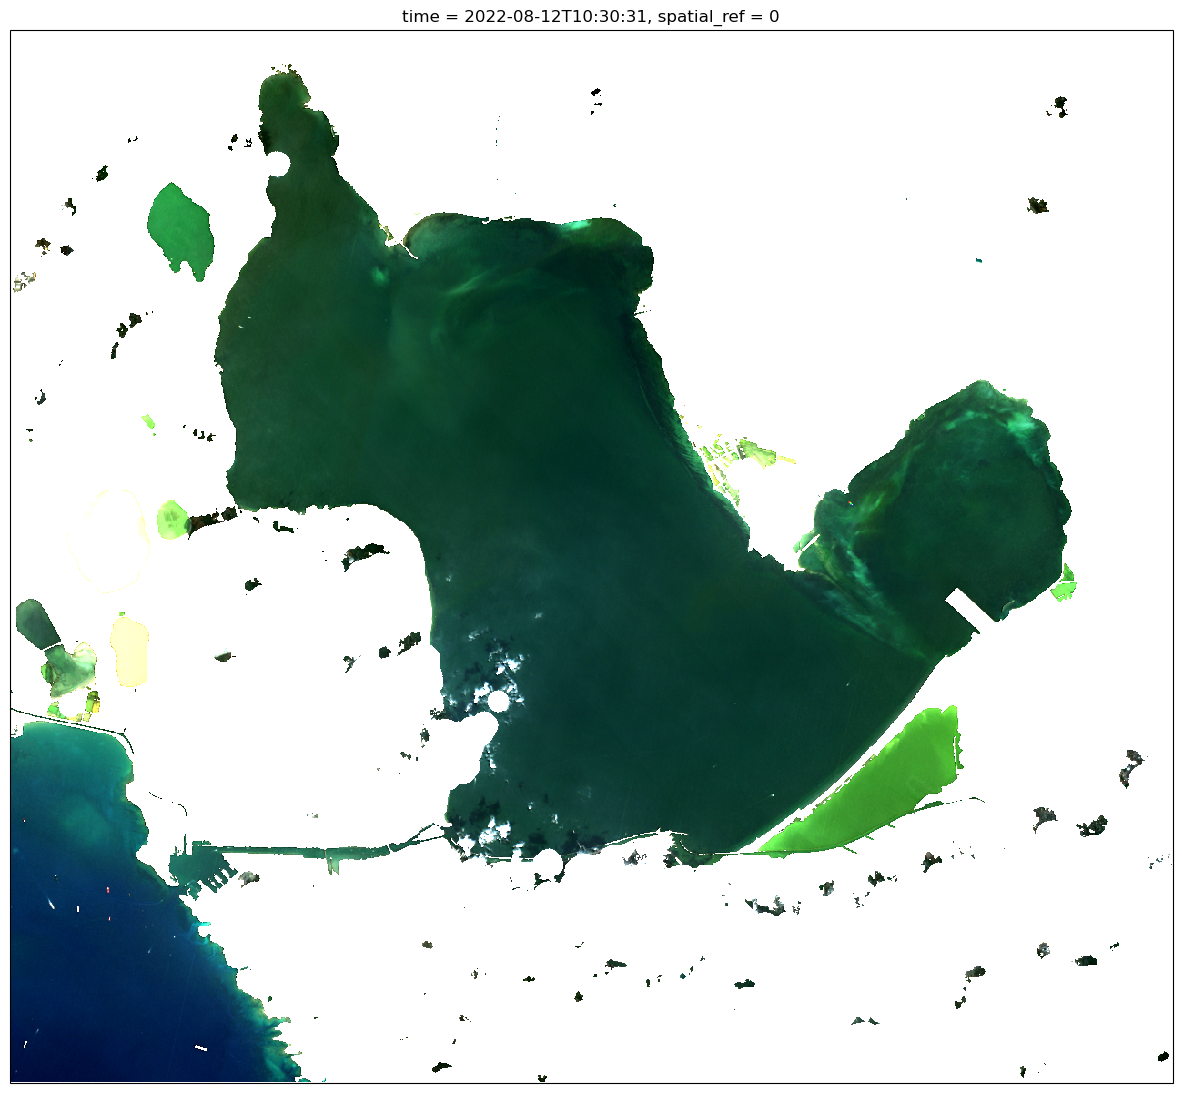

In [26]:
str_epsg = str(raster.rio.crs)
zone = str_epsg[-2:]
is_south = str_epsg[2] == 7
proj = ccrs.UTM(zone, is_south)
#.where(raster.mask==0)
plt.figure(figsize=(15,15))
(raster.Rrs.sel(wl=[665,560,490])).plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection=proj))

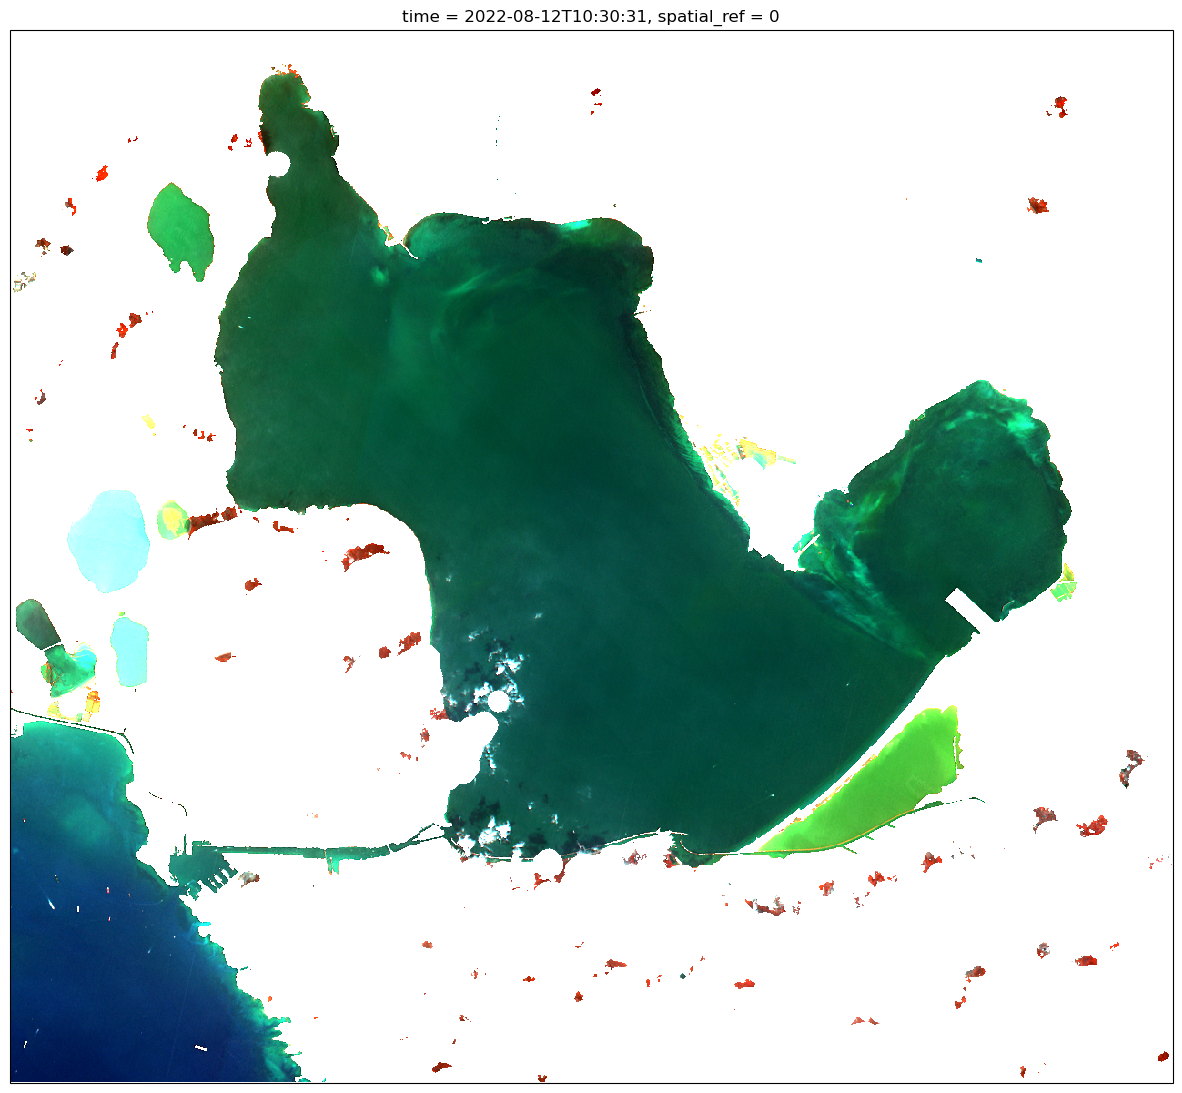

In [27]:
plt.figure(figsize=(15,15))
(raster.Rrs.sel(wl=[740,560,490])).plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection=proj))

<Figure size 1500x1500 with 0 Axes>

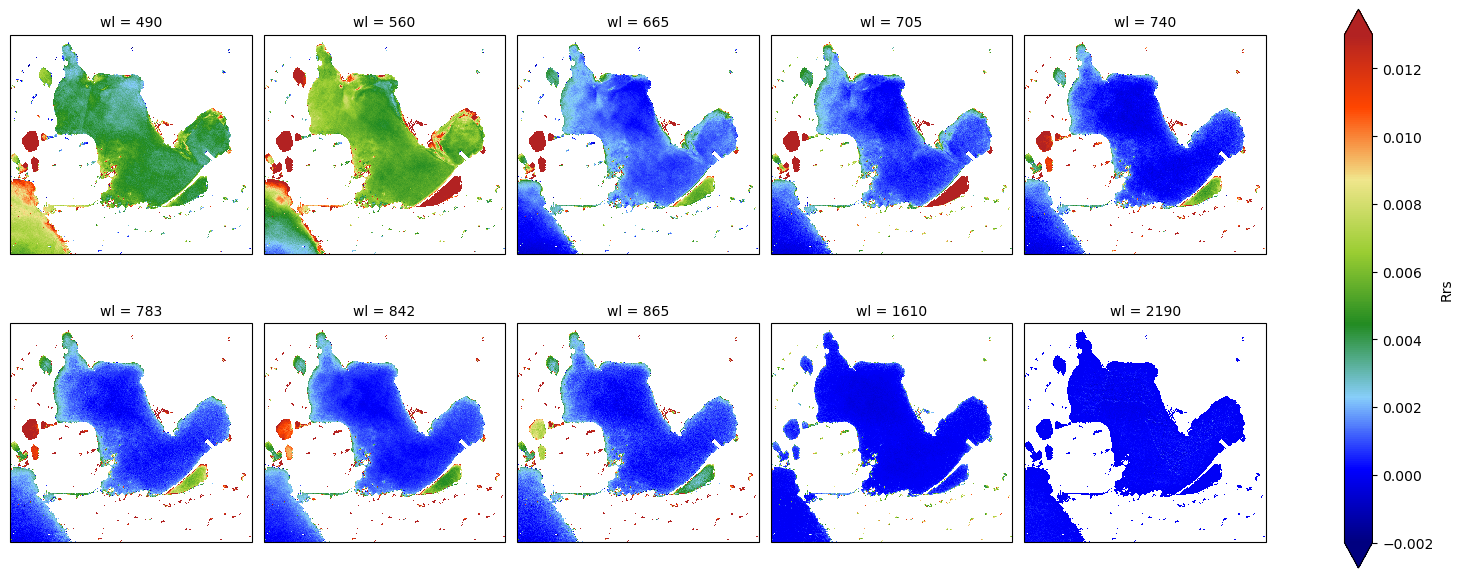

In [28]:
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list("",
                                                    ['navy', "blue", 'lightskyblue',
                                                       'forestgreen','yellowgreen',
                                                     "khaki",# "gold",
                                                     'orangered', 
                                                     "firebrick"])
plt.figure(figsize=(15,15))
raster.Rrs.isel(wl=slice(1,12)).plot.imshow(col='wl',col_wrap=5, cmap=cmap, robust=True,subplot_kws=dict(projection=proj),vmin=-0.002,vmax=0.013)

In [29]:
v=visual.ViewSpectral(raster.Rrs.load(),reproject=True)
v.minmax=[0,0.5]
v.visu()

Column
    [0] WidgetBox
        [0] Markdown(str)
        [1] Column
            [0] Row
                [0] Markdown(str)
                [1] RadioButtonGroup(options=[0, 1, 2, 3, 4, ...], value=2)
            [1] Row
                [0] Row
                    [0] Markdown(str)
                    [1] DatePicker(enabled_dates=[datetime.date(2022, ...], start=datetime.date(2022, ..., value=datetime.date(2022, ...)
                [1] Row
                    [0] Markdown(str)
                    [1] Select(options=['CartoDark', ...], value='CartoDark')
            [2] Row
                [0] Row
                    [0] Markdown(str)
                    [1] EditableRangeSlider(end=0.5, name='Range Slider', step=0.0001, value=(0, 0.02), width=300)
                [1] Row
                    [0] Markdown(str)
                    [1] FloatSlider(name='Opacity', step=0.05, value=0.95)
                [2] Row
                    [0] Markdown(str)
                    [1] Select(options=['CET_D13', 'bky', ...], value='CET_D13')
        [2] HoloViews(DynamicMap, height=800, sizing_mode='fixed', width=1200)

In [55]:
len(v.aoi_stream.data['xs'])

2

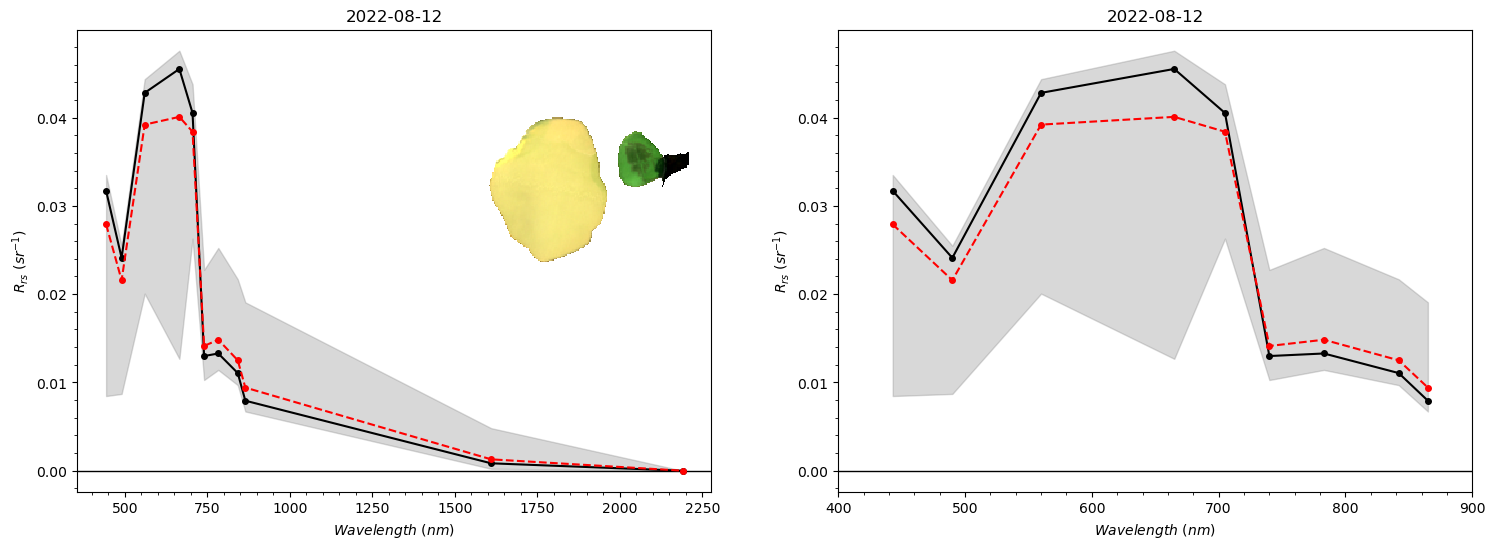

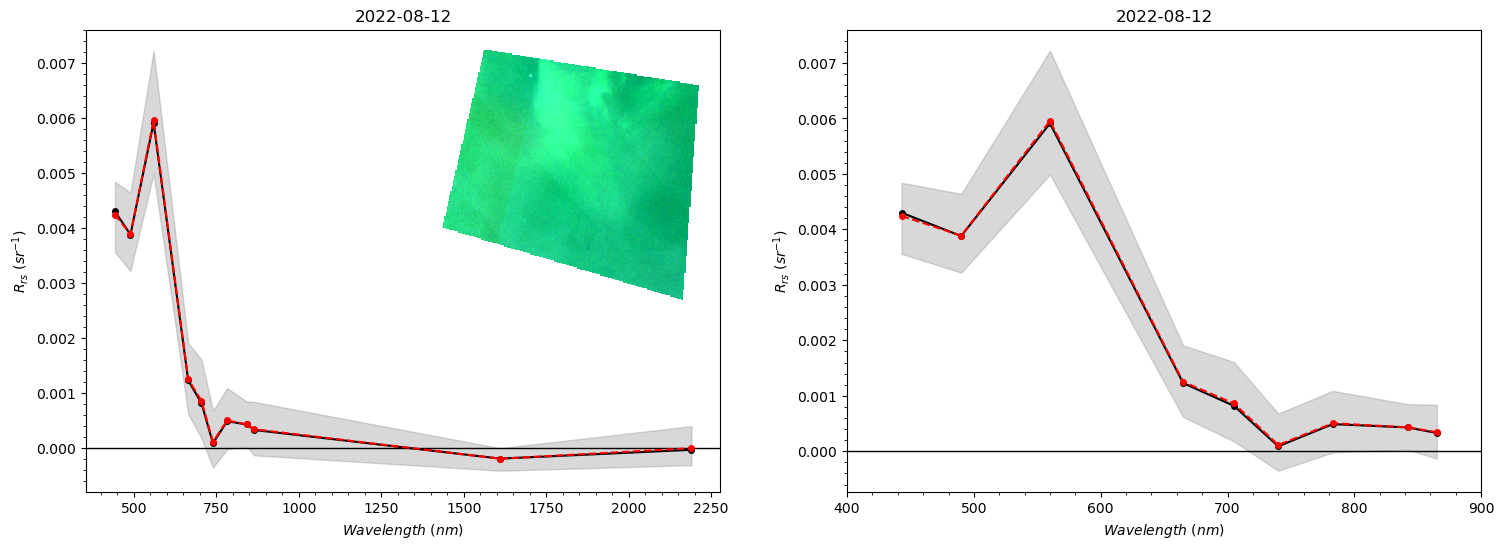

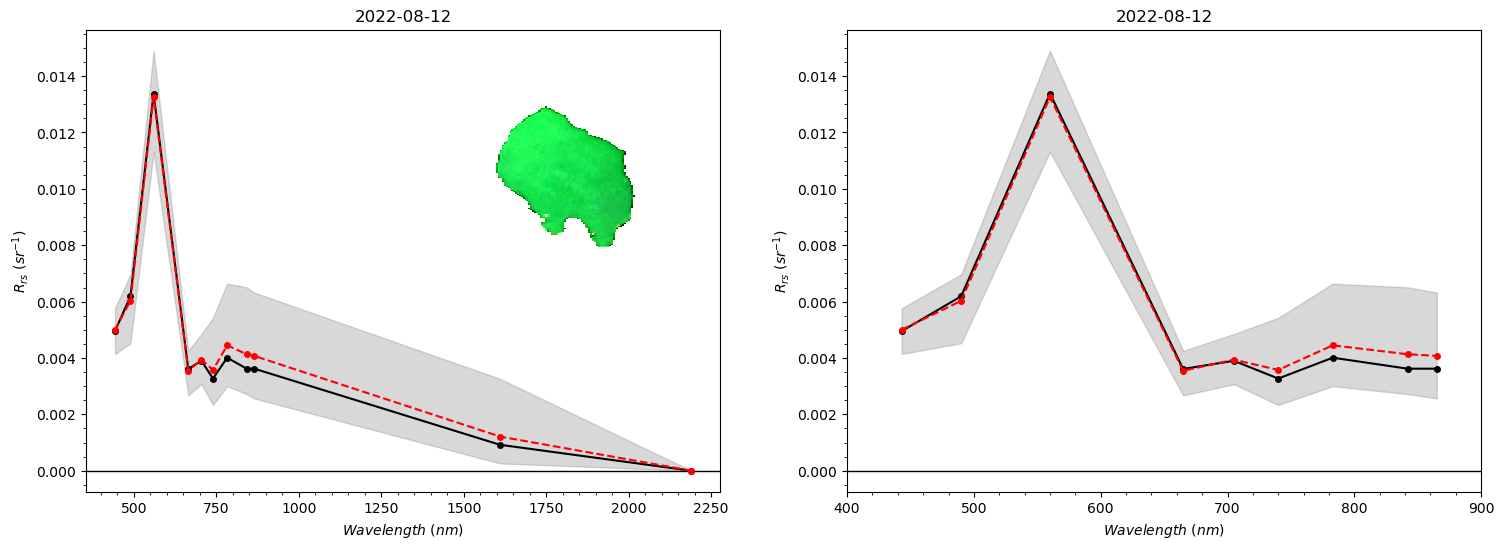

In [30]:
Npoly = len(v.aoi_stream.data['xs'])
for index in range(Npoly):
    geom_ = v.get_geom(v.aoi_stream,crs=raster.rio.crs,index=index)
    
    raster_clipped = xr.Dataset()
    
    for param in ['Rrs']:# raster.keys():
        da = raster[param].where(raster.mask==0)
        if 'x' in da.dims and 'y' in da.dims:
            raster_clipped[param]=da.rio.clip(geom_.geometry.values)
        else:
            raster_clipped[param]=da
    raster_clipped.attrs = raster.attrs
    
    
    stacked = raster_clipped.Rrs.sel(wl=slice(400,31000)).stack(gridcell=["y", "x"]).dropna('gridcell',thresh=0)
    
    
    group_coord ='wl'
    stat_coord='gridcell'
    stats = xr.Dataset({'median':stacked.groupby(group_coord).median(stat_coord)})
    stats['q25'] = stacked.groupby(group_coord).quantile(0.05,dim=stat_coord)
    stats['q75'] = stacked.groupby(group_coord).quantile(0.95,dim=stat_coord)
    stats['min'] = stacked.groupby(group_coord).min(stat_coord)
    stats['max'] = stacked.groupby(group_coord).max(stat_coord)
    stats['mean'] = stacked.groupby(group_coord).mean(stat_coord)
    stats['std'] = stacked.groupby(group_coord).std(stat_coord)
    stats['pix_num'] = stacked.count(stat_coord)
    
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    bands=[3,2,1]
    fig, axs = plt.subplots(1,2, figsize=(18, 6))#,sharey=True
    
    
    ax=axs[0]
    date = stats.time.dt.date.values
    axins = inset_axes(ax, width="45%", height="60%",
                   bbox_to_anchor=(.55, .4, 0.9, 0.9),
                   bbox_transform=ax.transAxes, loc=3)
    
    
    raster_clipped.Rrs.isel(wl=bands).plot.imshow(robust=True,ax=axins)
    axins.set_title('')
    axins.set_axis_off()
    for ii, ax in enumerate(axs):
        stats_=stats
        if ii == 1:
            stats_ =stats.sel(wl=slice(400,900))
        
        ax.minorticks_on()
        ax.axhline(y=0,color='k',lw=1)
        ax.plot(stats_.wl,stats_['median'],c='k',marker='o',ms=4)
        ax.plot(stats_.wl,stats_['mean'],c='red',ls='--',marker='o',ms=4)
        ax.fill_between(stats_.wl, stats_['q25'], stats_['q75'],alpha=0.3,color='grey')
        
        ax.set_xlabel(r'$Wavelength\ (nm)$')
        ax.set_ylabel(r'$R_{rs}\ (sr^{-1})$')
        ax.set_title(date)
    axs[1].set_xlim(400,900)
    plt.show()

## Check blue over green ratio for Chl retrieval with OC2 from NASA
$log_{10}(chlor\_a) = a_0 + \sum\limits_{i=1}^4 a_i \left(log_{10}\left(\frac{R_{rs}(\lambda_{blue})}{R_{rs}(\lambda_{green})}\right)\right)^i$

In [31]:
# NASA OC2 fro MODIS; bands 488, 547 nm
a = [0.2500,-2.4752,1.4061,-2.8233,0.5405]
# NASA OC2 for OCTS; bands 490, 565 nm
a = [0.2236,-1.8296,1.9094,-2.9481,-0.1718]

ratio = np.log10(raster.Rrs.isel(wl=1)/raster.Rrs.isel(wl=2))
logchl=0
for i in range(len(a)):
    logchl+=a[i]*ratio**i
chl = 10**(logchl)
chl.name='chl in mg.m-3 from OC2'

Set range of valid values

In [34]:
chl = chl.where((chl >= 0) & (chl <= 280))
chl.persist()



<xarray.DataArray 'chl in mg.m-3 from OC2' (y: 1158, x: 1278)> Size: 12MB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan, 0.12960126, 0.07877575, ...,        nan,        nan,
               nan],
       [       nan, 0.10034925, 0.10402828, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
    time         datetime64[ns] 8B 2022-08-12T10:30:31
  * x            (x) float64 10kB 6.57e+05 6.571e+05 ... 6.826e+05 6.826e+05
  * y            (y) float64 9kB 4.826e+06 4.826e+06 ... 4.802e+06 4.802e+06
    spatial_ref  int64 8B 0

In [36]:
visual.ViewParam(chl)

AttributeError: 'DataArray' object has no attribute 'data_vars'

In [37]:
raster = chl

shaded = []
for name, raster in chl.groupby('time'):
    img = tf.shade(raster.squeeze(),cmap=cc.bgyw, span=(0,10),how='log')
    img.name = str(name)
    shaded.append(img)

imgs = tf.Images(*shaded)
imgs.num_cols = 4
imgs

ValueError: Must pass non-zero number of levels/codes

# CDOM retrieval based on Brezonik et al, 2015


In [ ]:
a = [1.872,-0.83]
acdom = np.exp(a[0] + a[1] * np.log(Rrs_masked.isel(wl=1)/Rrs_masked.isel(wl=5)))
acdom.name='CDOM absorption at 440 nm-1'
acdom= acdom.where((acdom >= 0) & (acdom <= 10))
acdom.persist()

In [ ]:
visual.image_viewer().param_date(acdom,cmap='bgyw')

# Total suspended particulate matter (SPM) from Nechad et al., 2010, 2016 formulation
spm in mg/L

In [ ]:
a = [610.94*np.pi, 0.2324/np.pi]
Rrs_ = Rrs_masked.isel(wl=3)
spm = a[0] * Rrs_ / (1 - ( Rrs_/ a[1]))
spm.name='CDOM absorption at 440 nm-1'
spm= spm.where((spm >= 0) & (spm <= 150))
spm.persist()

In [ ]:
visual.image_viewer().param_date(spm,cmap='bgyw')

In [ ]:

shaded = []
for name, raster in dc.Rrs.Rrs.isel(time=-1).groupby('wl'):
    img = tf.shade(raster,cmap=cc.kbc)
    img.name = '{:.2f}'.format(name)+' nm'
    shaded.append(img)

imgs = tf.Images(*shaded)
imgs.num_cols = 5
imgs

In [ ]:
shaded = []
for name, raster in BRDFg.groupby('time'):
    img = tf.shade(raster,cmap=cc.gray, span=(0,0.025),how='log')
    img.name = str(name)
    shaded.append(img)

imgs = tf.Images(*shaded)
imgs.num_cols = 4
imgs

# Play with time series

In [ ]:
raster = spm

param = raster.name
third_dim = 'time'
time= raster.time.data
Ntime = len(time)
ds = hv.Dataset(raster.persist())
im= ds.to(hv.Image, ['x', 'y'], dynamic=True).opts(cmap= 'RdBu_r',colorbar=True,clim=(0,100))#.hist(bin_range=(0,0.02) ) 

polys = hv.Polygons([])
box_stream = hv.streams.BoxEdit(source=polys)
dmap, dmap_std=[],[]

def roi_curves(data,ds=ds):    
    if not data or not any(len(d) for d in data.values()):
        return hv.NdOverlay({0: hv.Curve([],'time', param)})

    curves,envelope = {},{}
    data = zip(data['x0'], data['x1'], data['y0'], data['y1'])
    for i, (x0, x1, y0, y1) in enumerate(data):
        selection = ds.select(x=(x0, x1), y=(y0, y1))
        mean = selection.aggregate(third_dim, np.nanmean).data
        print(mean)
        #std = selection.aggregate(third_dim, np.std).data
        time = mean[third_dim]

        curves[i]= hv.Curve((time,mean[param]),'time', param) 

    return hv.NdOverlay(curves)


# a bit dirty to have two similar function, but holoviews does not like mixing Curve and Spread for the same stream
def roi_spreads(data,ds=ds):    
    if not data or not any(len(d) for d in data.values()):
        return hv.NdOverlay({0: hv.Curve([],'time', param)})

    curves,envelope = {},{}
    data = zip(data['x0'], data['x1'], data['y0'], data['y1'])
    for i, (x0, x1, y0, y1) in enumerate(data):
        selection = ds.select(x=(x0, x1), y=(y0, y1))
        mean = selection.aggregate(third_dim, np.nanmean).data
        std = selection.aggregate(third_dim, np.nanstd).data
        time = mean[third_dim]

        curves[i]=  hv.Spread((time,mean[param],std[param]),fill_alpha=0.3)

    return hv.NdOverlay(curves)

mean=hv.DynamicMap(roi_curves,streams=[box_stream])
std =hv.DynamicMap(roi_spreads, streams=[box_stream])    


In [ ]:
# visualize and play
graphs = ((mean*std ).relabel(param))
layout = (im * polys +graphs    ).opts(
    opts.Curve(width=600, framewise=True), 
    opts.Polygons(fill_alpha=0.2, color='green',line_color='black'), 
    ).cols(2)
layout 